# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


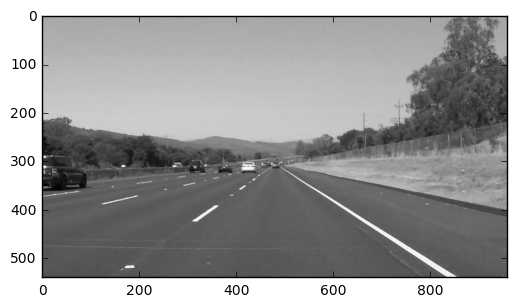

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Processing image: solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


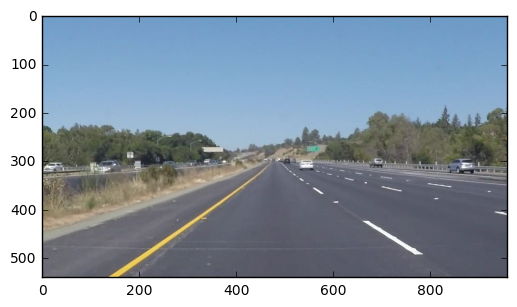

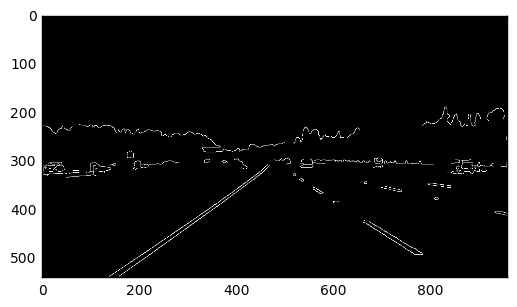

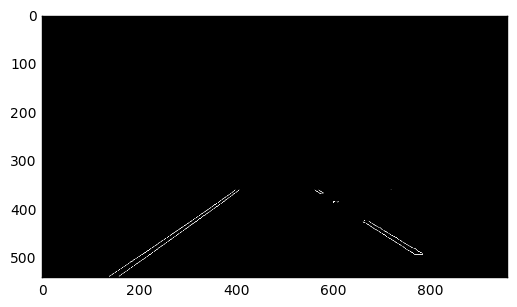

Hough lines:


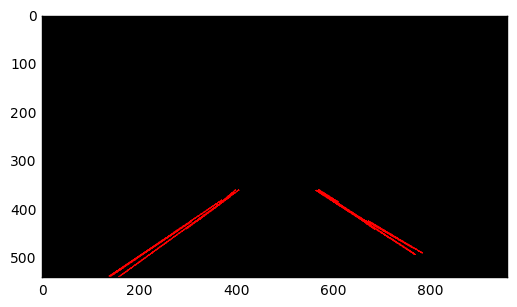

Line: 172 529 405 360
Slope: -0.725321888412
left bottom_x: 156.834319527
Line: 139 539 307 425
Slope: -0.678571428571
left bottom_x: 137.526315789
Line: 672 424 783 490
Slope: 0.594594594595
right bottom_x: 867.090909091
Line: 564 361 768 493
Slope: 0.647058823529
right bottom_x: 840.636363636
Line: 138 538 370 381
Slope: -0.676724137931
left bottom_x: 135.044585987
Line: 158 539 264 462
Slope: -0.72641509434
left bottom_x: 156.623376623
Line: 351 401 398 360
Slope: -0.872340425532
left bottom_x: 191.658536585
Line: 668 424 763 479
Slope: 0.578947368421
right bottom_x: 868.363636364
Line: 318 425 388 373
Slope: -0.742857142857
left bottom_x: 163.192307692
Line: 569 360 685 441
Slope: 0.698275862069
right bottom_x: 826.777777778
Line: 579 368 666 424
Slope: 0.64367816092
right bottom_x: 846.214285714
Line: 297 440 355 397
Slope: -0.741379310345
left bottom_x: 162.11627907
Line: 570 360 610 385
Slope: 0.625
right bottom_x: 858.0
Line: 576 368 769 493
Slope: 0.647668393782
right bottom_x

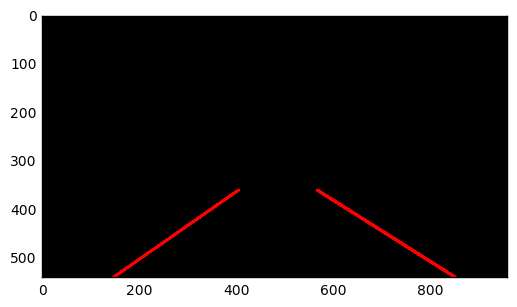

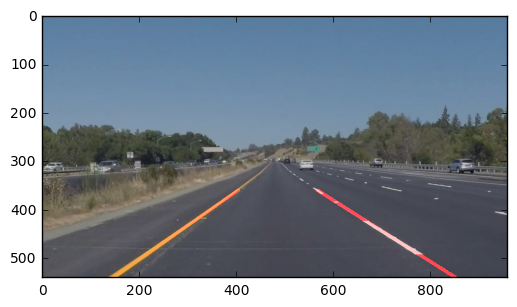

Processing image: solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


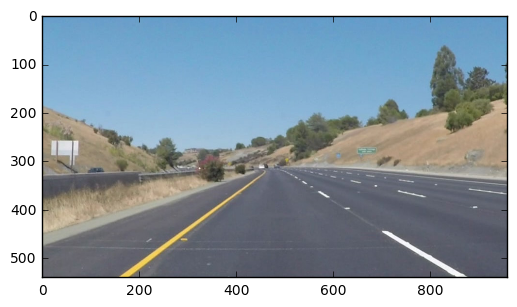

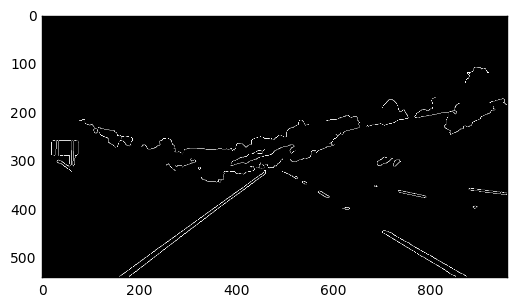

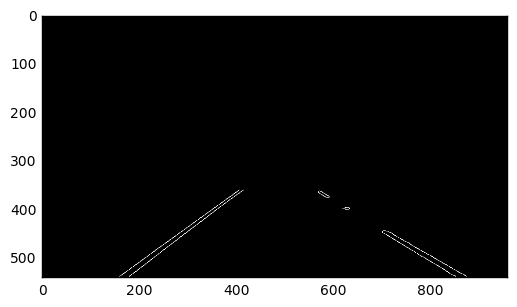

Hough lines:


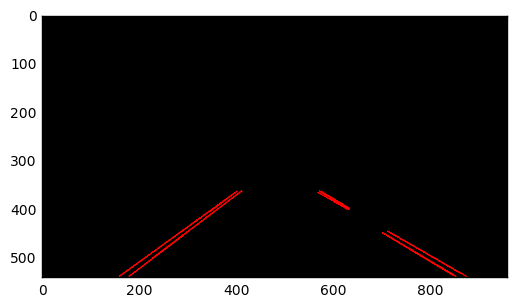

Line: 159 538 401 363
Slope: -0.723140495868
left bottom_x: 156.234285714
Line: 228 500 411 362
Slope: -0.754098360656
left bottom_x: 174.956521739
Line: 714 446 874 538
Slope: 0.575
right bottom_x: 877.47826087
Line: 701 448 852 538
Slope: 0.596026490066
right bottom_x: 855.355555556
Line: 179 538 290 454
Slope: -0.756756756757
left bottom_x: 176.357142857
Line: 571 362 632 400
Slope: 0.622950819672
right bottom_x: 856.736842105
Line: 568 365 629 400
Slope: 0.573770491803
right bottom_x: 873.0
Line: 346 404 393 369
Slope: -0.744680851064
left bottom_x: 163.371428571
Line: 574 363 633 398
Slope: 0.593220338983
right bottom_x: 872.371428571
Line: 711 445 862 532
Slope: 0.576158940397
right bottom_x: 875.885057471
Line: 702 449 847 536
Slope: 0.6
right bottom_x: 853.666666667
Left: [array([[159, 538, 401, 363]], dtype=int32), array([[228, 500, 411, 362]], dtype=int32), array([[179, 538, 290, 454]], dtype=int32), array([[346, 404, 393, 369]], dtype=int32)]
Right [array([[714, 446, 874, 53

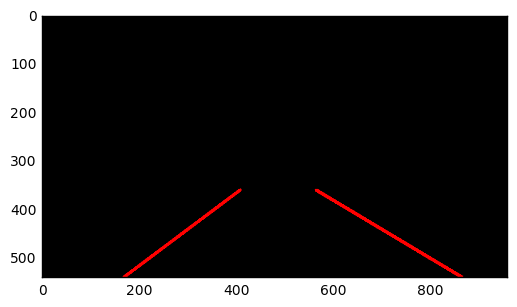

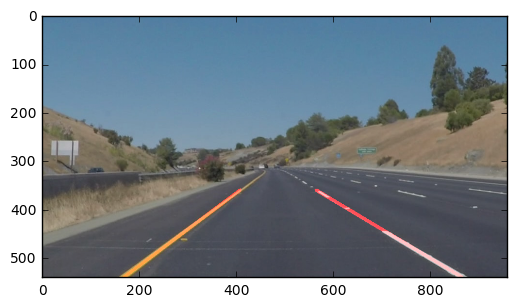

Processing image: solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


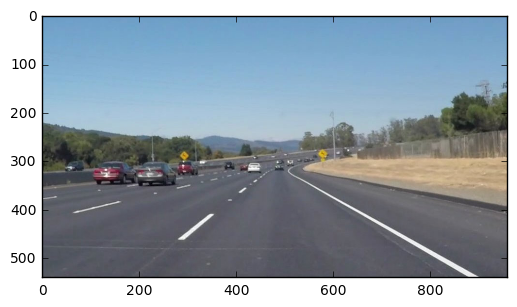

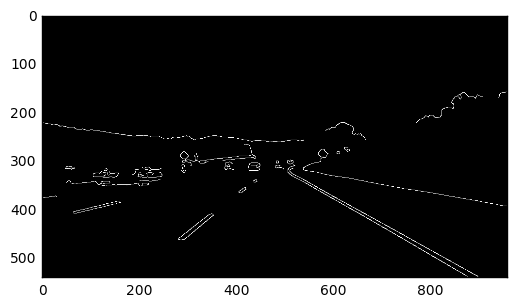

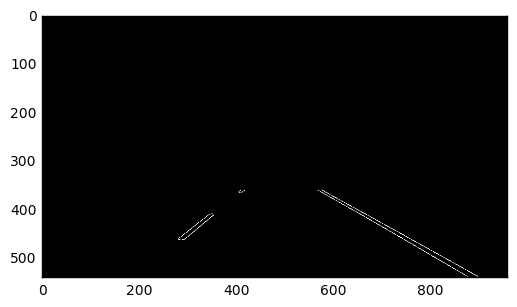

Hough lines:


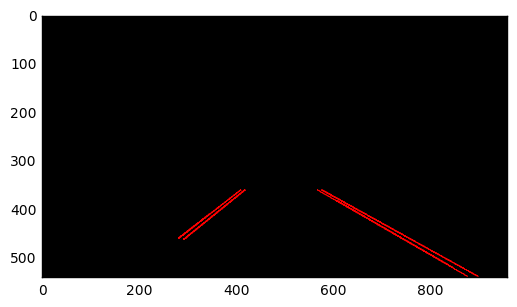

Line: 575 360 897 538
Slope: 0.552795031056
right bottom_x: 900.617977528
Line: 567 360 876 538
Slope: 0.576051779935
right bottom_x: 879.471910112
Line: 291 462 417 360
Slope: -0.809523809524
left bottom_x: 194.647058824
Line: 281 460 409 360
Slope: -0.78125
left bottom_x: 178.6
Line: 577 360 898 538
Slope: 0.554517133956
right bottom_x: 901.606741573
Line: 607 382 846 520
Slope: 0.577405857741
right bottom_x: 880.637681159
Line: 292 462 418 360
Slope: -0.809523809524
left bottom_x: 195.647058824
Line: 281 459 344 410
Slope: -0.777777777778
left bottom_x: 176.857142857
Left: [array([[291, 462, 417, 360]], dtype=int32), array([[281, 460, 409, 360]], dtype=int32), array([[292, 462, 418, 360]], dtype=int32), array([[281, 459, 344, 410]], dtype=int32)]
Right [array([[575, 360, 897, 538]], dtype=int32), array([[567, 360, 876, 538]], dtype=int32), array([[577, 360, 898, 538]], dtype=int32), array([[607, 382, 846, 520]], dtype=int32)]
Pick two:


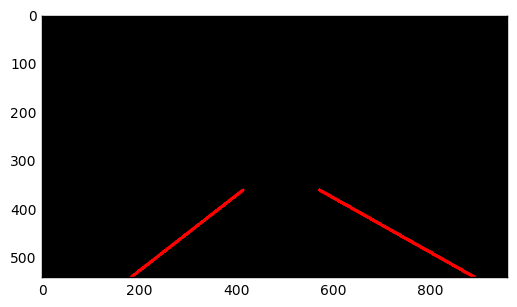

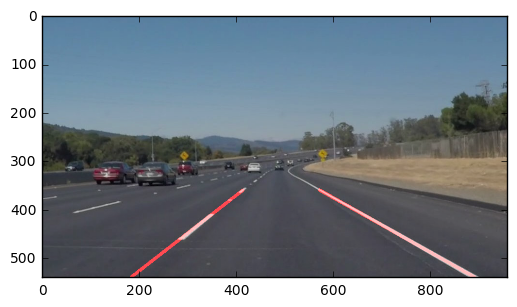

Processing image: whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


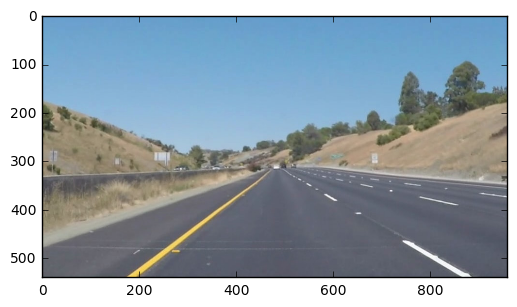

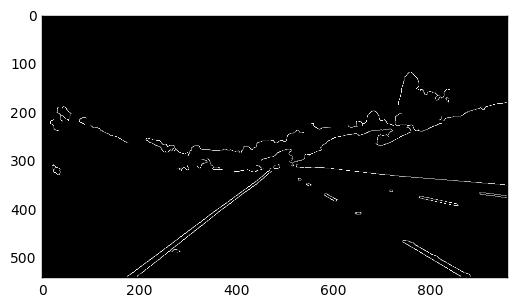

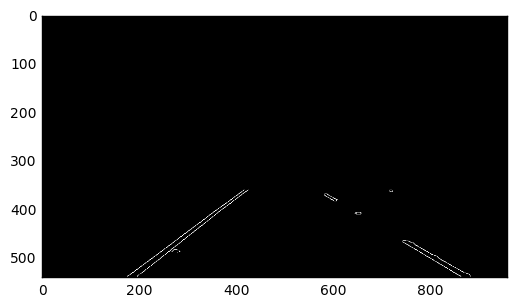

Hough lines:


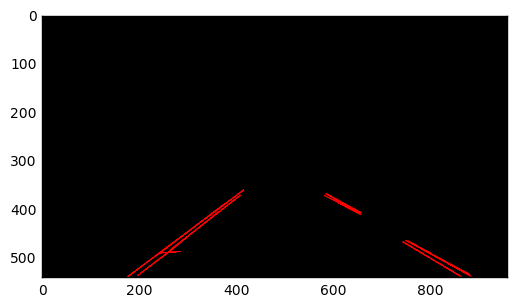

Line: 176 539 377 388
Slope: -0.751243781095
left bottom_x: 174.668874172
Line: 266 482 408 371
Slope: -0.781690140845
left bottom_x: 191.801801802
Line: 751 465 883 538
Slope: 0.55303030303
right bottom_x: 886.616438356
Line: 743 467 862 538
Slope: 0.596638655462
right bottom_x: 865.352112676
Line: 197 536 273 478
Slope: -0.763157894737
left bottom_x: 191.75862069
Line: 234 496 415 360
Slope: -0.75138121547
left bottom_x: 175.441176471
Line: 581 371 654 410
Slope: 0.534246575342
right bottom_x: 897.333333333
Line: 586 368 657 407
Slope: 0.549295774648
right bottom_x: 899.128205128
Line: 754 465 881 535
Slope: 0.551181102362
right bottom_x: 890.071428571
Line: 585 368 656 410
Slope: 0.591549295775
right bottom_x: 875.761904762
Line: 248 498 363 405
Slope: -0.808695652174
left bottom_x: 196.064516129
Line: 749 464 879 533
Slope: 0.530769230769
right bottom_x: 892.188405797
Line: 240 490 284 487
Slope: -0.0681818181818
Left: [array([[176, 539, 377, 388]], dtype=int32), array([[266, 482, 

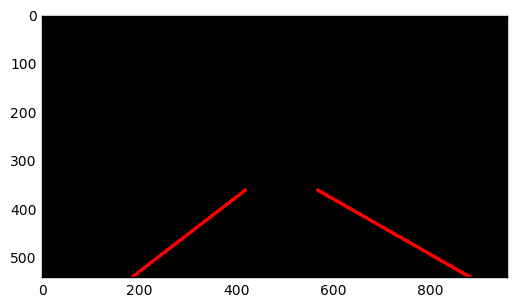

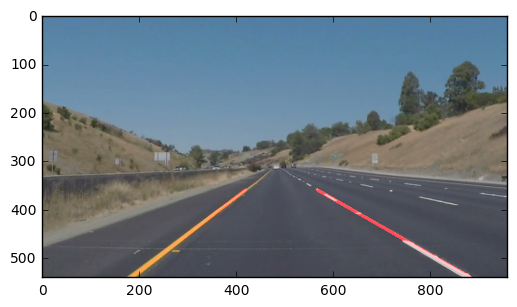

Processing image: solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


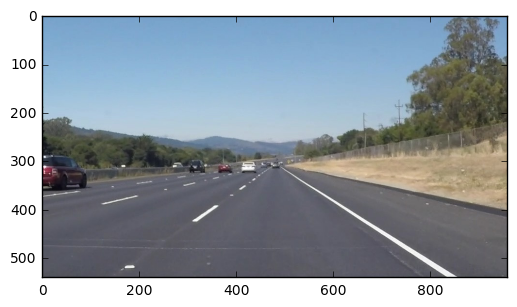

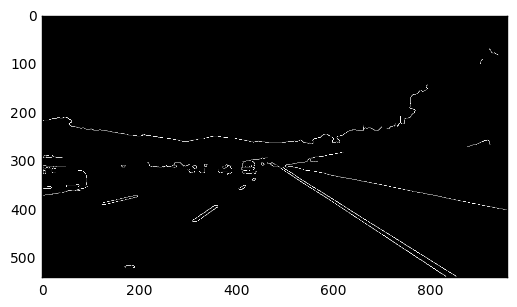

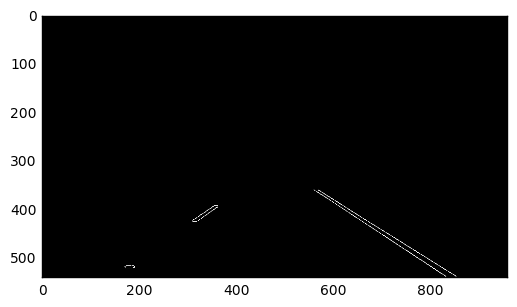

Hough lines:


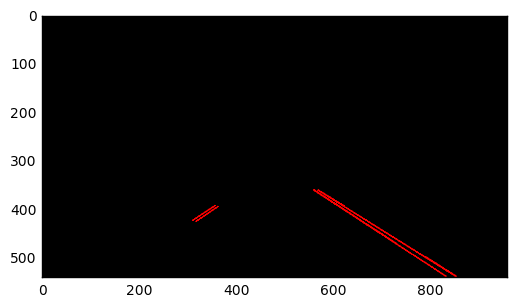

Line: 569 361 852 538
Slope: 0.625441696113
right bottom_x: 855.197740113
Line: 559 360 832 538
Slope: 0.652014652015
right bottom_x: 835.06741573
Line: 317 425 362 394
Slope: -0.688888888889
left bottom_x: 150.064516129
Line: 560 360 729 470
Slope: 0.650887573964
right bottom_x: 836.545454545
Line: 310 423 356 392
Slope: -0.673913043478
left bottom_x: 136.387096774
Line: 568 360 622 393
Slope: 0.611111111111
right bottom_x: 862.545454545
Line: 790 498 853 538
Slope: 0.634920634921
right bottom_x: 856.15
Left: [array([[317, 425, 362, 394]], dtype=int32), array([[310, 423, 356, 392]], dtype=int32)]
Right [array([[569, 361, 852, 538]], dtype=int32), array([[559, 360, 832, 538]], dtype=int32), array([[560, 360, 729, 470]], dtype=int32), array([[568, 360, 622, 393]], dtype=int32), array([[790, 498, 853, 538]], dtype=int32)]
Pick two:


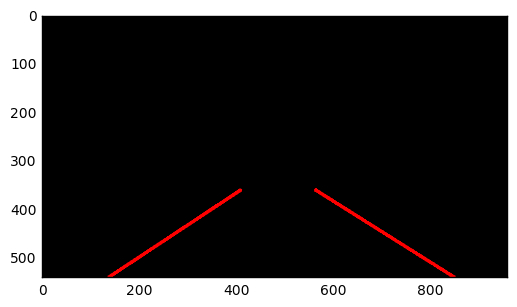

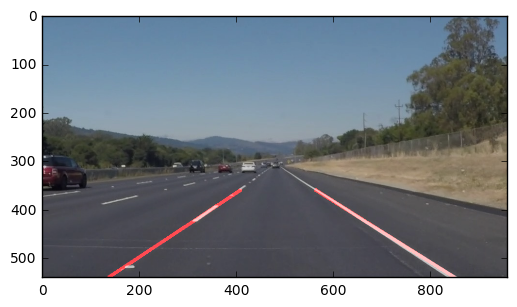

Processing image: solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


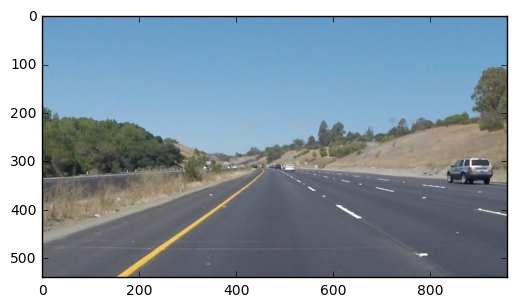

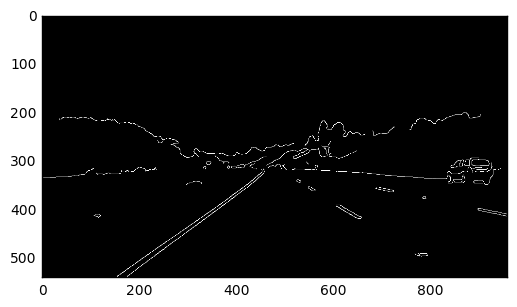

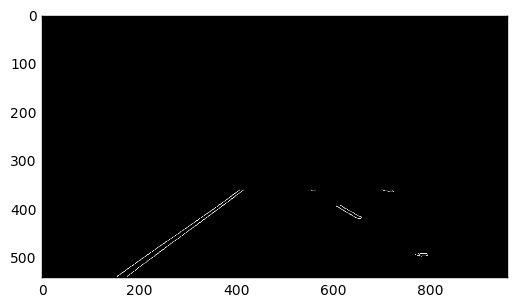

Hough lines:


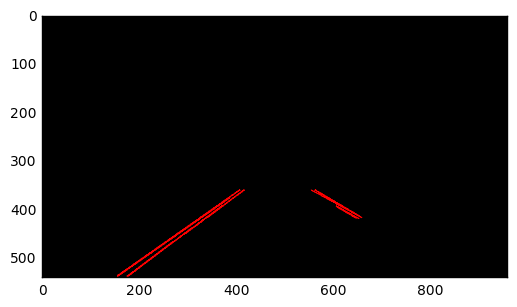

Line: 176 538 309 438
Slope: -0.751879699248
left bottom_x: 173.34
Line: 155 538 385 377
Slope: -0.7
left bottom_x: 152.142857143
Line: 155 537 407 360
Slope: -0.702380952381
left bottom_x: 150.728813559
Line: 315 435 371 392
Slope: -0.767857142857
left bottom_x: 178.255813953
Line: 606 393 652 419
Slope: 0.565217391304
right bottom_x: 866.076923077
Line: 554 360 658 417
Slope: 0.548076923077
right bottom_x: 882.421052632
Line: 175 538 269 467
Slope: -0.755319148936
left bottom_x: 172.352112676
Line: 606 394 647 418
Slope: 0.585365853659
right bottom_x: 855.416666667
Line: 341 416 416 360
Slope: -0.746666666667
left bottom_x: 174.928571429
Line: 296 449 339 416
Slope: -0.767441860465
left bottom_x: 177.424242424
Line: 562 360 655 415
Slope: 0.591397849462
right bottom_x: 866.363636364
Left: [array([[176, 538, 309, 438]], dtype=int32), array([[155, 538, 385, 377]], dtype=int32), array([[155, 537, 407, 360]], dtype=int32), array([[315, 435, 371, 392]], dtype=int32), array([[175, 538, 269

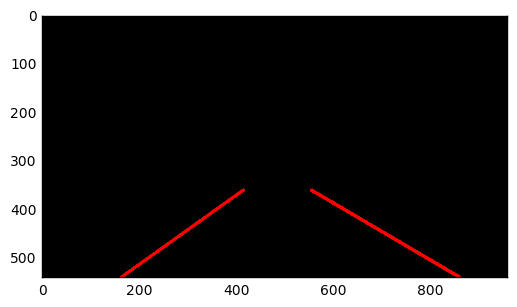

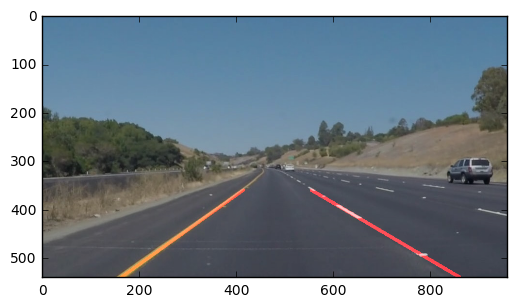

In [4]:
import os
test_images_folder = "test_images/"
result_images_folder = "result_images"

if not os.path.exists(result_images_folder):
    os.makedirs(result_images_folder)

def calculate_bottom_x(x, y, slope, y1):
    return (y1-y)/slope + x

def draw_single_line(line_img, lines, ratio = 2.0/3):
    imshape = line_img.shape
    imgwidth = imshape[1]
    imgheight = imshape[0]
    if lines:
        x = []
        y = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                x.append(x1)
                x.append(x2)
                y.append(y1)
                y.append(y2)
                
        new_line = np.polyfit(x, y, 1)
        start_x = (imgheight - new_line[1])/new_line[0]
        end_x = (imgheight*ratio - new_line[1])/new_line[0]
        cv2.line(line_img, (int(start_x), imgheight), (int(end_x), int(imgheight*ratio)), [255, 0, 0], 5)
    return line_img

def find_lane_lines(img, rho, theta, threshold, min_line_len, max_line_gap, slop_threshold = 0.5, ratio = 2.0/3, debug = False):
    imshape = image.shape
    imgwidth = imshape[1]
    imgheigh = imshape[0]
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_left = []
    lines_right = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if debug:
                print("Line:", x1, y1, x2, y2)
            if x1 == x2:
                continue #TODO not sure if the lane line could be a vertical line
            else:
                slope = float(y1-y2)/(x1-x2)
                if debug:
                    print("Slope:", slope)
                if slope < slop_threshold and slope > -slop_threshold: # filter lines by slope
                    continue
                elif slope >= slop_threshold: #right line
                    bottom_x = calculate_bottom_x(x1, y1, slope, imgheigh)
                    if debug:
                        print("right bottom_x:", bottom_x)
                    if bottom_x < imgwidth/2 or bottom_x > imgwidth: # this line should fall on right
                        continue
                    else:
                        lines_right.append(line)
                else : #left line
                    bottom_x = calculate_bottom_x(x1, y1, slope, imgheigh)
                    if debug:
                        print("left bottom_x:", bottom_x)
                    if bottom_x < 0 or bottom_x > imgwidth/2: # this line should fall on left
                        continue
                    else:
                        lines_left.append(line)

    if debug:
        print("Left:", lines_left)
        print("Right", lines_right)
    
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_single_line(line_img, lines_left, ratio)
    draw_single_line(line_img, lines_right, ratio)
    return line_img

def process_image_helper(image, height_ratio = 2.0/3, width_ratio = 1.0/4, debug=False):
    if debug:
        print('This image is:', type(image), 'with dimensions:', image.shape)
        plt.imshow(image)
        plt.show()

    gray = grayscale(image)    
    blur_gray = gaussian_blur(gray, 9)
    
    edges = canny(blur_gray, 50, 150)
    if debug:
        plt.imshow(edges, cmap='gray')
        plt.show()

    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),(imshape[1]*width_ratio, imshape[0]*height_ratio), (imshape[1] - imshape[1]*width_ratio, imshape[0]*height_ratio), (imshape[1],imshape[0])]], dtype=np.int32)
    masked = region_of_interest(edges, vertices)
    if debug:
        plt.imshow(masked, cmap='gray')
        plt.show()
    
    if debug:
        lines_img = hough_lines(masked, 2, np.pi/180, 20, 40, 60)
        print("Hough lines:")
        plt.imshow(lines_img)
        plt.show()

    line_img = find_lane_lines(masked, 2, np.pi/180, 20, 40, 60, ratio=height_ratio, debug=debug)
    if debug:
        print("Pick two:")
        plt.imshow(line_img)
        plt.show()
    
    result = weighted_img(line_img, image)
    if debug:
        plt.imshow(result)
        plt.show()
    return result

image_files = os.listdir(test_images_folder)
for image_file in image_files:
    print("Processing image:", image_file)
    image = mpimg.imread(test_images_folder + image_file)
    result = process_image_helper(image, debug=True)
    mpimg.imsave("result_images/" + image_file, result)


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return process_image_helper(image)

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 26.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 54.8 s, sys: 1.76 s, total: 56.6 s
Wall time: 8.78 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:29<00:00, 22.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 3min 10s, sys: 6.11 s, total: 3min 16s
Wall time: 30.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

In my implementation, there are actually some assumptions:
1) We only need to detect the two lines of the lane our vehicle is riding on.
2) The lane lines fall in the region defined by ((0, imshape[0]),(imshape[1]/4, imshape[0]*2/3), (imshape[1]*3/4,imshape[0]*2/3), (imshape[1],imshape[0]))
3) There are exactly one line on left and one line on the right.
3) The slope of left line is less than -1 and the slope of right line is grater than 1.

Those assumption can make things easier but also introduced some restrictions, in some special conditions, my algorithms might not work.

I found that at some point, the parameters of canny and HoughLinesP won't change the result too much, just in a certain range, you can't reach a better result but just tuning the parameters without additional algorithms.

I can think of another way to improve this algorithms if I can assume that the vehicle doesn't change lane in the video. I can keep the lane lines detected in the last frame and assume that won't change two much in the next frame. Then I can just pick the lines in the next frame which are closest to the lane lines I have in the previous frame.

And I didn't think about the performance here yet, I know that in real self-driving-car, I should be able to detect lines in a limited time.


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Looks like there are many assumptions I made previously can't apply in this one. Especially there are too many curved line in this video, currently have no idea to improve that without impact my previous result.

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))